# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 7</span>

### Exercise 07.1
In the MD/MC code we have provided, include tail corrections for potential energy, $U$, and pressure $P$.

### Exercise 07.2

Use the MD/MC code to <span style="color:red">print out instantaneous values of potential energy per particle, $U/N$, along **equilibrated** Monte Carlo simulations</span> (of $M=5\times 10^5$ MC steps and where the Metropolis acceptance ratio has been fixed approximately to 50%) in the following thermodynamic conditions:
- solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
- liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
- gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

1. <span style="color:red">Once this data has been produced, compute and make pictures with a python script of the autocorrelation functions of $U/N$ to approximately estimate how large the blocks in your simulations should be.
2. Use the same data to study, with a python script, the estimation of the statistical uncertainties of the expectation value of $U/N$ for different size of the blocks in the data blocking technique, from $L=M/N=10$ to $L=5\times 10^3$, being $N$ the number of blocks. <span style="color:red">Make pictures of these statistical uncertainties as a function of $L$.</span> What you observe in the statistical uncertainties after that the block size is large enough (from the point of view of the data blocking technique)?

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
states = ("solid", "liquid", "gas")

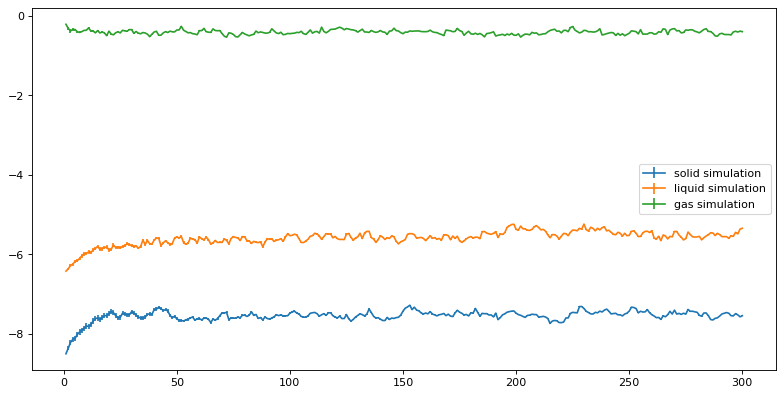

In [6]:
figure(figsize=(12, 6), dpi=80)
for state in states:
    #plt.title(f'{labels[count]}')
    x_eq,s_eq,err_eq = np.loadtxt(f"./data/equilibration/output_pot_{state}.dat", usecols=(0,1,2), unpack='true')       
    plt.errorbar(x_eq[:300],s_eq[:300],yerr = err_eq[:300],label=f"{state} simulation")
plt.legend()

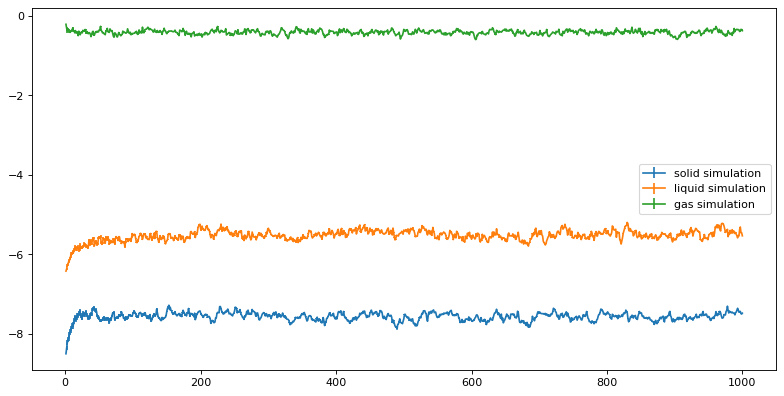

In [7]:
figure(figsize=(12, 6), dpi=80)
for state in states:
    #plt.title(f'{labels[count]}')
    x_eq,s_eq,err_eq = np.loadtxt(f"./data/equilibration/output_pot_{state}.dat", usecols=(0,1,2), unpack='true')       
    plt.errorbar(x_eq,s_eq,yerr = err_eq,label=f"{state} simulation")
plt.legend()

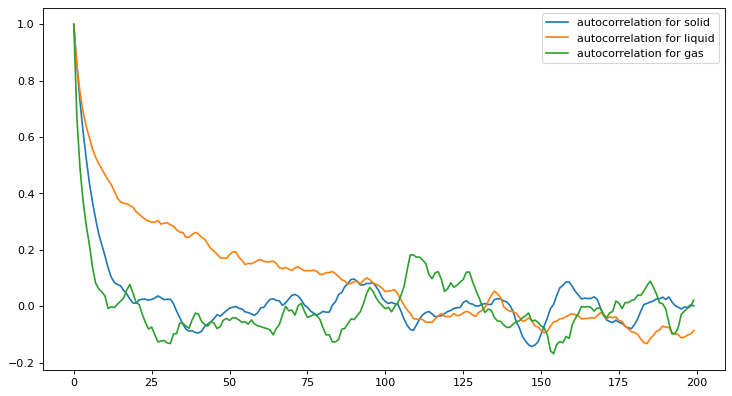

In [12]:
xs = []
for state in states:
    xs.append(np.loadtxt(f"./data/equilibration/output_pot_{state}.dat", usecols=(1), unpack='true'))
def AutoCorr(t, state,x):
    a1=0
    a2=0
    a3=0
    v1=0
    v2=0
    x=x[:10000]
    tmax=len(x)
    for i in range(tmax-t):
        a1+=x[i]*x[i+t]
        a2+=x[i]
        a3+=x[i+t]
    for i in range(tmax):
        v1+=x[i]*x[i]
        v2+=x[i] 
    var = (v1/tmax)-(v2/tmax)**2
    return (a1/(tmax-t) - a2*a3/((tmax-t)*(tmax-t)))/var  

figure(figsize=(11, 6), dpi=80)
for i in range(3):
    a = [AutoCorr(t,states[i],xs[i]) for t in range(200)]
    plt.plot(a,label="autocorrelation for "+states[i])
plt.legend()

##### OBSERVATION
From an observational criteria we can say that after 100 steps the trends behave in an uncorrelate way.


##### STEP 3
In order to discover whitch is the best lengh for block statistic I compute unincerties along the block lengh (L): from $L=M/N=10$ to $L=5\times 10^3$

In [11]:
M=50000
def error(AV,AV2,n):
    if (n==0): err=0
    else: err = np.sqrt((AV2 - AV*AV)/n)
    return err

def Average(L,vec):
    N=int(M/L)
    cum_ave = 0
    cum_err = 0
    cum_av2 = 0
    for i in range(N):
        sum_ave = 0
        for j in range(L):
            k = j+i*L
            sum_ave += vec[k]
        cum_ave += sum_ave/L
        cum_av2 += sum_ave*sum_ave/L/L
    cum_ave = cum_ave/N
    cum_av2 = cum_av2/N
    cum_err += error(cum_ave,cum_av2,N)   
    return cum_err

In [12]:
nstep = 25
errs=[]
for i in range(3):
    print('----------------------')
    print(states[i]+" compiling...   ")
    err = []
    x = np.loadtxt(f"./data/equilibration/output_pot_{states[i]}.dat", usecols=(1), unpack='true')
    for L in range(10,5000,nstep):
        err.append(Average(L,x))
    errs.append(err)
    print("Done!\n")


----------------------
solid compiling...   
Done!

----------------------
liquid compiling...   
Done!

----------------------
gas compiling...   
Done!



(10, 5000)

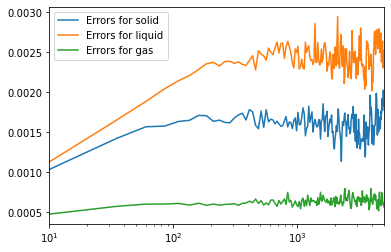

In [10]:
for i in range(3):
    plt.plot(range(10,5000,nstep),errs[i],label="Errors for "+states[i])
plt.legend()
plt.xscale('log')
plt.xlim(10,5000)

### Exercise 07.3

<span style="color:red">Include the calculation of the radial distribution function, $g(r)$, as a function of the radial distance $r$ among particles, with $r \in \left[ 0; L/2\right]$ inside the MD/MC code</span>: average value of $g(r)$ in each block, final average value of $g(r)$ with statistical uncertainties in a separate file.

In [13]:
npart=108
rho=[1.1,0.8,0.05]
def plot_g(L,ex,t):
    states =("solid", "liquid", "gas")
    col=("blue", "green", "orange")
    m =("o",'d','x')
    figure(figsize=(15, 6), dpi=80)

    for i in range(3):
        #print(f"\nCompute g(r) function for {states[i]} simulation\n")
        g = np.loadtxt(f"./data/{ex}/output_g_{states[i]}_{t}.dat", unpack='true')
        g_err = np.loadtxt(f"./data/{ex}/output_g_err_{states[i]}_{t}.dat", unpack='true')
        L = (npart/rho[i])**(1/3)
        n = 1/100*L/2
        plt.errorbar(np.arange(len(g[1:,0]))*n,g[1:,0],yerr = g_err[1:,0],label=states[i]+" g(r)",color=col[i],linewidth=2, marker=m[i] ,markersize=7)
        plt.legend()
        plt.xlim([0, 3])
    plt.grid()

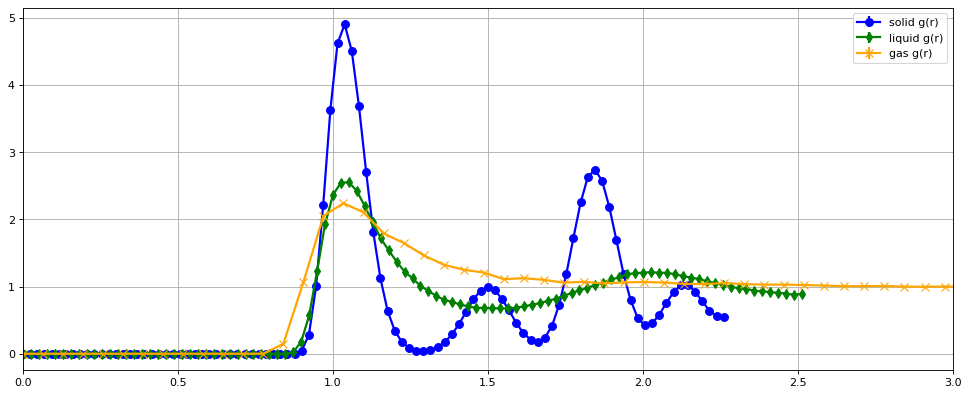

In [14]:
plot_g(2000,"ex3",1)

### Exercise 07.4

By means of your upgraded MC code, equilibrate and <span style="color:red">perform MC NVT simulations via a Lennard-Jones model</span> of Argon ($\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu) in the following conditions:
1. solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
2. liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
3. gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

show in pictures the obtained average values and uncertainties for the potential energy per particle, $U/N$, the pressure $P$ and the radial distribution function $g(r)$ in Lennard-Jones units ... <span style="color:red"> and compare your MC results for the radial distribution function, $g(r)$, with those obtained with Molecular Dynamics NVE simulations in similar thermodynamic conditions.</span>

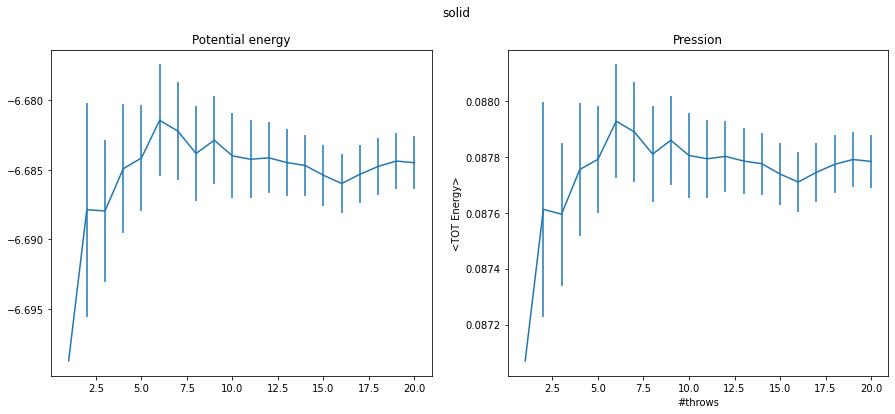

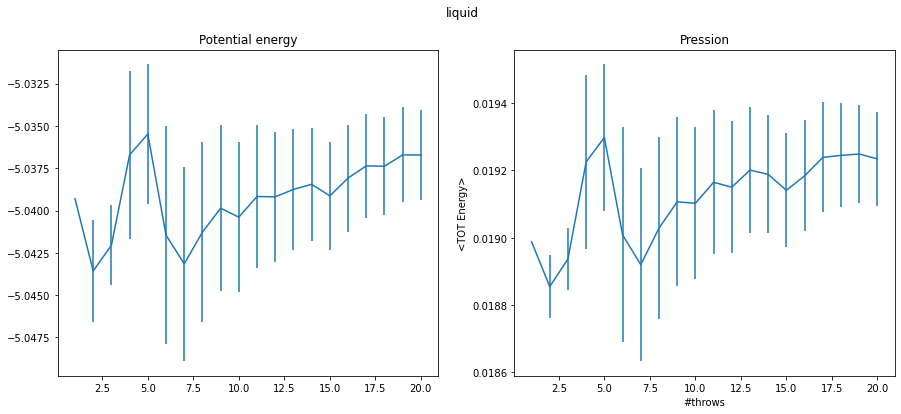

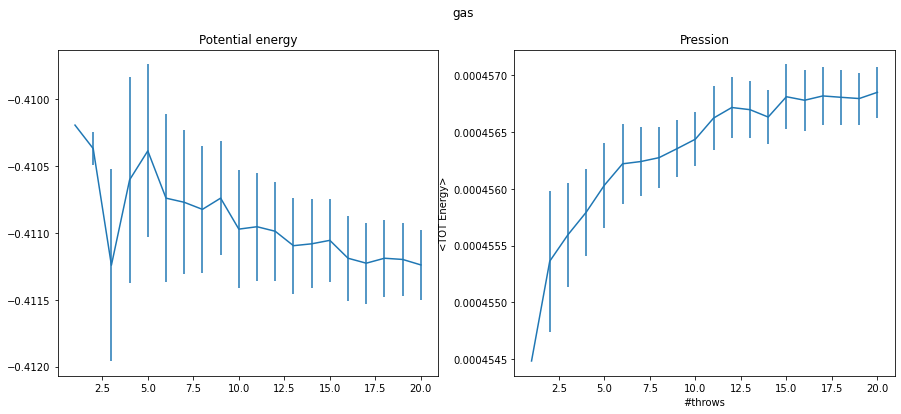

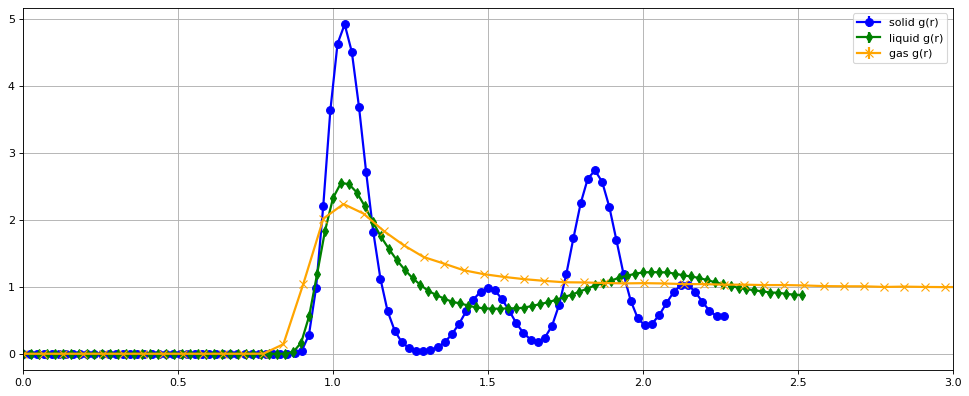

In [15]:
file_name =["epot","pres"]

for state in states:
    fig, axs = plt.subplots(1, 2,figsize=(15,6))
    for i in range(2):
        x,s,err = np.loadtxt(f"./data/ex4/output_{file_name[i]}_{state}_1.dat", usecols=(0,2,3), unpack='true')
        axs[i].errorbar(x,s,yerr=err)
    axs[0].set_title("Potential energy")
    axs[1].set_title("Pression")
    fig.suptitle(state)
    plt.xlabel('#throws')
    plt.ylabel('<TOT Energy>')

plot_g(2000,"ex4",1)

plt.show()

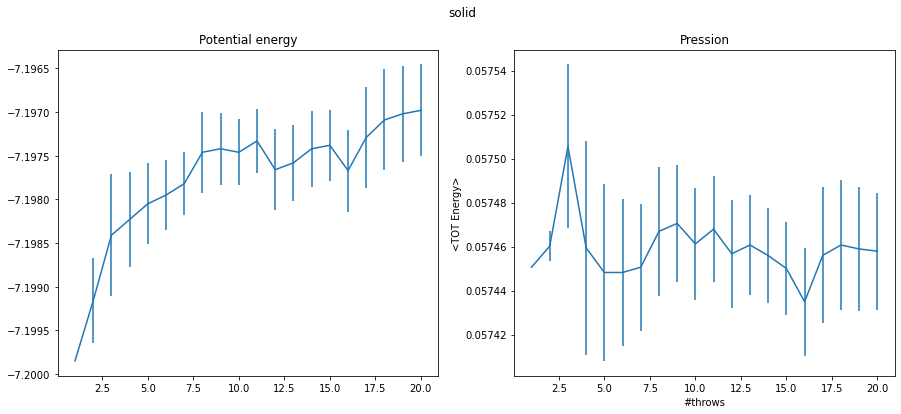

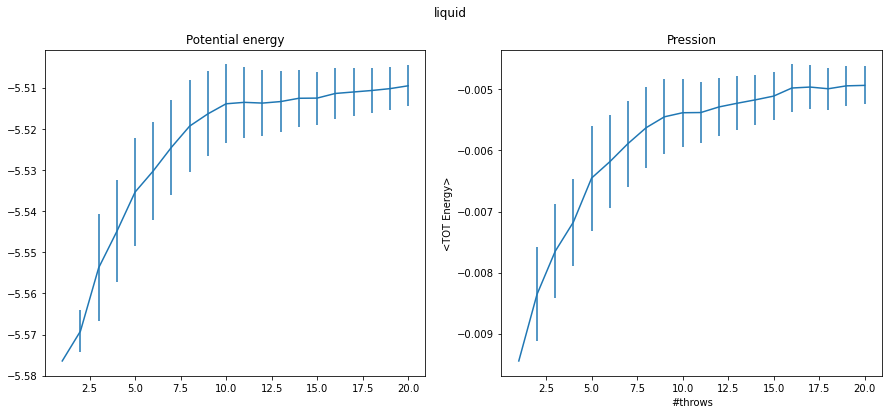

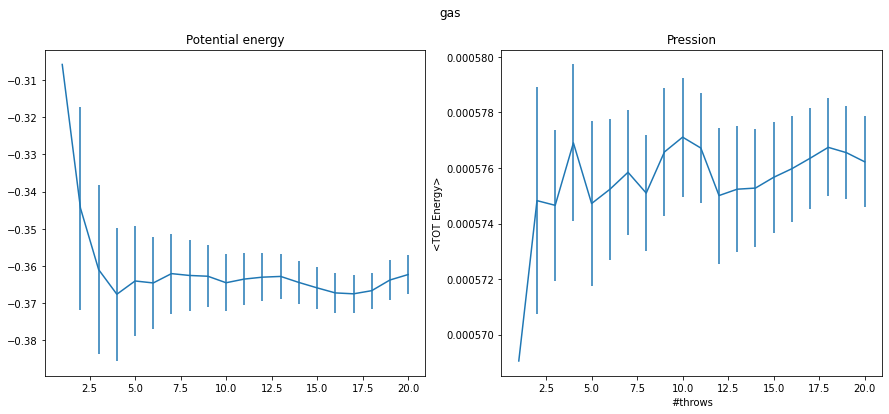

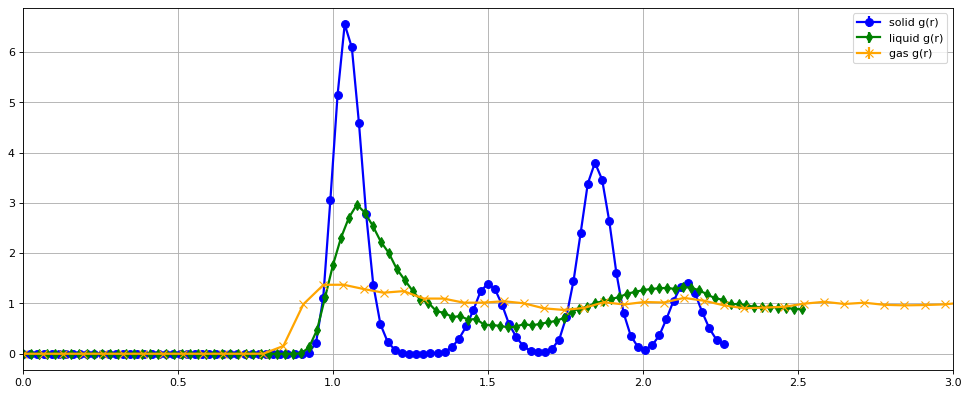

In [16]:
file_name =["epot","pres"]

for state in states:
    fig, axs = plt.subplots(1, 2,figsize=(15,6))
    for i in range(2):
        x,s,err = np.loadtxt(f"./data/ex4/output_{file_name[i]}_{state}_0.dat", usecols=(0,2,3), unpack='true')
        axs[i].errorbar(x,s,yerr=err)
    axs[0].set_title("Potential energy")
    axs[1].set_title("Pression")
    fig.suptitle(state)
    plt.xlabel('#throws')
    plt.ylabel('<TOT Energy>')

plot_g(2000,"ex4",0)

plt.show()

Match

In [19]:
npart=108
rho=[1.1,0.8,0.05]
def plot_g_match(L,ex,i):
    col=("blue","red")
    m =("o","D")
    alg = ("MD","MC")
    figure(figsize=(15, 6), dpi=80)
    for t in range(2):
        #print(f"\nCompute g(r) function for {states[i]} simulation\n")
        g = np.loadtxt(f"./data/{ex}/output_g_{states[i]}_{t}.dat", unpack='true')
        g_err = np.loadtxt(f"./data/{ex}/output_g_err_{states[i]}_{t}.dat", unpack='true')
        L = (npart/rho[i])**(1/3)
        n = 1/100*L/2
        plt.errorbar(np.arange(len(g[1:,0]))*n,g[1:,0],yerr = g_err[1:,0],label="g(r) "+alg[t],color=col[t],linewidth=2, marker=m[t] ,markersize=7)
    plt.ylabel("<g(r)> "+states[i])
    plt.legend()
    plt.xlim([0, 3])
    plt.grid()

[None, None, None]

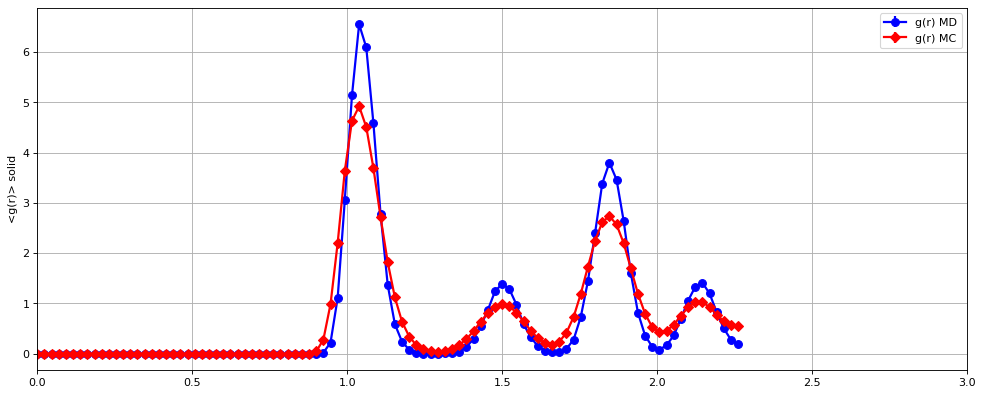

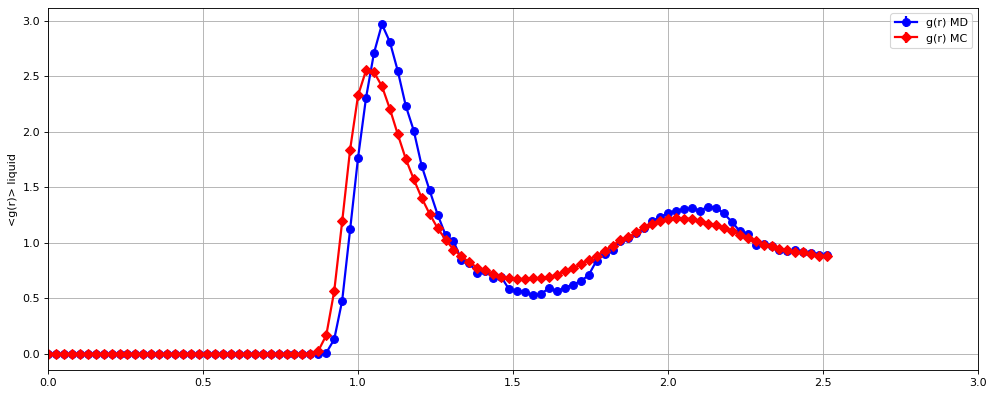

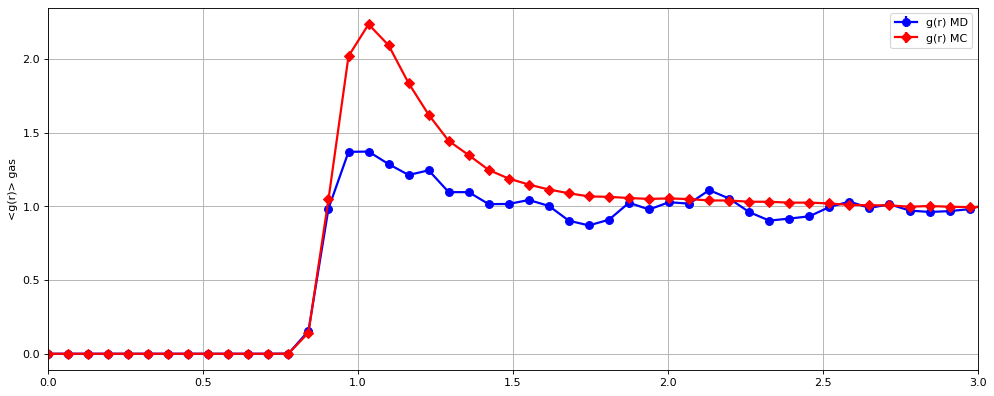

In [20]:
[plot_g_match(2000,"ex4",i) for i in range(3)]